In [3]:
import numpy as np
import pandas as pd
from keras.models import *
from keras.layers import *
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from functools import partial

class Symmetrize(Layer):
    def __init__(self, **kwargs):
        super(Symmetrize, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Symmetrize, self).build(input_shape)

    def call(self, x):
        x_ = Permute([2, 1, 3])(x)
        x = (x+x_)/2
        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[1])

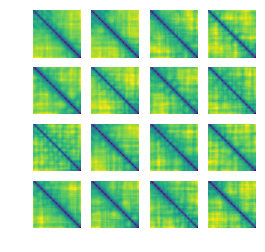

In [3]:
# plotting generator results

z = np.random.normal(size=(16,100))
gen160 = load_model('../models/gen160.h5', custom_objects={'Symmetrize':Symmetrize})
dis160 = load_model('../models/dis160.h5')

predictions = gen160.predict(z)
fig = plt.figure(figsize=(4,4))
for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0])
    plt.axis('off')
plt.show()

In [3]:
predictions = np.load('../predictions/test9st.npz')
stitches = np.load('../predictions/stitches_test.npz')
test_df = pd.read_csv('../../test_input.csv')
seq_len = test_df['length'].values

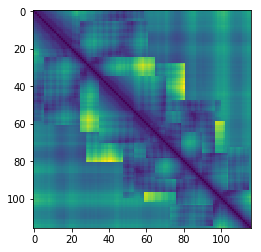

In [59]:
plt.imshow(predictions['arr_0'])

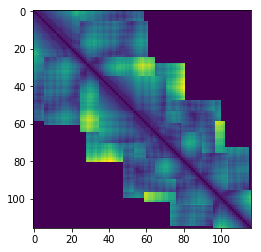

In [60]:
plt.imshow(stitches['arr_0'][:seq_len[0],:seq_len[0]])

(1, 160, 160, 1)


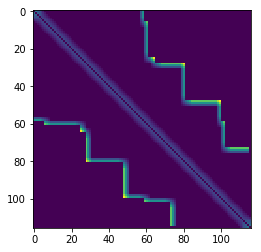

In [100]:
def get_binary_mask(stitches):
    return (stitches > 0).astype(np.int32)
    
def get_weight_matrix(M):
    n = M.shape[0]
    W = np.zeros_like(M).astype(np.float32)
    for i in range(n):
        for j in range(n):
            if M[i,j] != 0:
                x0 = max(i-3, 0)
                x1 = min(i+3, n-1)
                y0 = max(j-3, 0)
                y1 = min(j+3, n-1)
                nbhd = (1 - M[x0:x1, y0:y1])
                W[i,j] = nbhd.sum() / float(nbhd.size)
    return W
            
M = get_binary_mask(stitches['arr_0'][:116,:116])
W = np.zeros((1,160,160,1)).astype(np.float32)
W[0,:116,:116,0] = get_weight_matrix(M)
plt.imshow(W[0,:116,:116,0])
print W.shape

In [76]:
''' Loss function for Keras attempt '''
def inpainting_loss(y_stitch, y_gen, weights):
    Lc = tf.subtract(y_gen, y_stitch)
    Lc = tf.multiply(weights, Lc)
    Lc = K.abs(Lc)
    Lc = K.sum(Lc)
    
    Lp = tf.subtract(1., dis160.predict(y_gen))
    Lp = tf.log(Lp)
    Lp = tf.multiply(0.003, Lp)
    
    L = tf.add(Lc, Lp)
    print 'L', type(L)
    return L

inpaint_loss = partial(inpainting_loss, weights=W)
inpaint_loss.__name__ = 'inpaint_loss' 

In [111]:
''' Loss function for own gradient descent  '''
def inpainting_loss(y_stitch, y_gen, weights):
    Lc = np.sum(np.abs((weights * (y_gen - y_stitch))))
    Lp = 0.003 * np.log(1. - dis160.predict(y_gen))[0, 0] # there is only one value
    return Lc+Lp

inpaint_loss = partial(inpainting_loss, weights=W)
inpaint_loss.__name__ = 'inpaint_loss' 

In [136]:
''' attempt to inpaint the first test image '''

p = np.zeros((1, 160,160, 1))
p[0, :116, :116, 0] = predictions['arr_0']
p = 2 * p / p.max() - 1 # target

gen160 = load_model('../models/gen160.h5', custom_objects={'Symmetrize':Symmetrize})

z = np.random.normal(size=(1,100))
z_last = z.copy()


import time

t = time.time()

for i in range(100):
    g = gen160.predict(z)
    loss = inpaint_loss(p, g)
    grads = np.zeros((1,100), dtype=np.float32)
    for i in range(100):
        z_ = z.copy()
        z_[0, i] = z[0, i] + 1e-4
        g_ = gen160.predict(z_)
        loss_ = inpaint_loss(p, g_)
        grads[0, i] = (loss_ - loss) * 1e4
    grads /= (np.sqrt(np.mean(np.square(grads)))+ 1e-5) # for smooth descent
    z -= grads * 0.1
    
    print np.abs(z - z_last).sum()
    if np.abs(z - z_last).sum() < 1e-3:
        break
    z_last = z.copy()

print 'time', time.time() - t
    

8.011115262750536
8.101555741392076
8.183806616114452
8.160127931740135
8.379847221076488
8.286283602647018
7.964144327852409
8.230629004421644
7.910743347078096
7.873544178844895
8.019754162058234
8.157899348414503
7.77453805191908
7.981526158793713
8.066348576408927
8.187376927351579
8.132407196622808
8.107972064055502
8.078845919531886
8.090782345941989
8.059264179551974
8.149782539752778
8.147198786959052
8.093000992143061
7.930453135515563
8.048290988372173
8.144456425157841
8.083386012927804
8.05870736320503
8.229012015974149


KeyboardInterrupt: 